In [1]:
import matplotlib.patches as patches
import mitsuba as mi 
mi.set_variant("cuda_ad_rgb")
from matplotlib import colors
import drjit as dr
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../../../")
from matplotlib.patches import Polygon
from PDE2D.Coefficient import *
from PDE2D.utils import *
from PDE2D.BoundaryShape import *
from PDE2D.Solver import *


In [2]:
origin = [0, 0]
radius = 0.22
epsilon = 1e-4
resolution = [1024, 1024]
seed = 5
colors = ["blue", "green", "magenta", "black", "purple"]


In [3]:
image = np.array([[0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [0, 16, 32, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [0,  0, 16, .5, .5, .5, .5, .3, .0,  0,  0,  0,  0,  0,  0,  0],
                  [0,  0,  0,  2,  8,  6,  6,  2,  0,  0,  0,  0,  0,  0,  0,  0],
                  [0, .5,  1,  2,  8,  8,  3,  2,  0,  0,  0,  0,  0,  0,  0,  0],
                  [0,  1,  2,  3,  8,  8,  8,  3,  2,  0,  0,  0,  0,  0,  0,  0],
                  [0,  1,  2,  3,  4,  4,  5,  6,  2,  2,  0,  0,  0,  0,  0,  0],
                  [0,  1,  1,  1,  2,  2,  3,  3,  1,  1,  0,-.4,-.4,-.4,  0,  0],
                  [0, .5, .5,  0,  0,  0,  0,  0,  0,  0,-.7,-.8,-.4,  0,  0,  0],
                  [0,  0,  0,  0,  0,  2,  0,  0,  0,  0,-.8,-.8,-.3,-.3,  0,  0],
                  [0,  0,  0,  0,  2,  0,  0,  1,  0,  0,-.8,-.9,-.9,-.9,-.3,  0],
                  [1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,-.4,-.4,-.3,  0,  0],
                  [1,  1,  1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [1,  1,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [1,  1,  2,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

image = np.array([[0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [0, 16, 32, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [0,  0, 16, .5,  0,  0, 0,  0, .0,  0,  0,  0,  0,  0,  0,  0],
                  [0,  0,  0,  2,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [0, .5,  1,  2,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])
image +=1


α = DiskTextureCoefficient("diffusion", image, radius = radius, origin = origin, out_val = 1, 
                           constant_thickness=0.00)
f = ConstantCoefficient("source", 0)
σ = ConstantCoefficient("screening", 0)
dirichlet = ConstantCoefficient("dirichlet", 0)


shape = CircleShape(dirichlet=[dirichlet], radius=radius, epsilon=epsilon)
data_holder = DataHolder(shape=shape, bbox_center = [0,0], bbox_length=2.2 * radius, α=α, σ=σ, f=f,
                              majorant_safety_low= 2, majorant_safety_high = 1.1, 
                              max_window_grid=64, max_mipmap_res = resolution[0])
bbox = data_holder.bbox
data_holder.effective_σ.numpy().shape

data_holder.create_accelaration()


Computed Majorants:
blue = 0.00430446770042181
green = 12007.7138671875
red = 0.06381554901599884
purple = 25.69681167602539
yellow = 0.10955928266048431


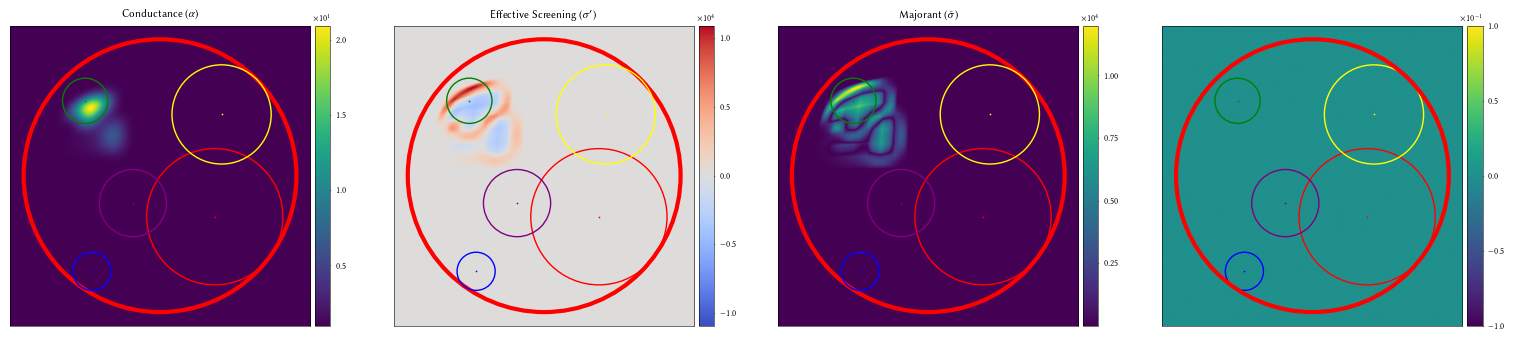

In [4]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (19,5))
data_holder.α.visualize(ax1, bbox = bbox, resolution = resolution)
shape.sketch(ax1,bbox,resolution)
ax1.set_title("Conductance ($\\alpha$)")
eff= data_holder.effective_σ.numpy()
max_ = max(np.max(eff), np.max(-eff))  
plot_image(eff, ax2, input_range = (-max_,max_), cmap = "coolwarm")
ax2.set_title("Effective Screening ($\\sigma'$)")
shape.sketch(ax2, bbox, data_holder.effective_σ.numpy().shape)
data_holder.majorant_tex.visualize(ax3, bbox, resolution)
shape.sketch(ax3, bbox, resolution)
ax3.set_title("Majorant ($\\bar{\sigma}$)")

points_np = np.array([[-0.5, -0.7],
                   [-0.55,  0.55],
                   [ 0.4, -0.3],
                   [-0.2, -0.2],
                   [ 0.45,  0.45]]) * radius
points =Point2f(points_np.T)

bi = data_holder.shape.boundary_interaction(points)
d_radius, majorants, z = data_holder.get_Rσz(bi.origin, bi.r)
radius_np = d_radius.numpy()
points_s = point2sketch(points, bbox, resolution).numpy()
radii_x, radii_y, radii_s =dist2sketch(d_radius, bbox, resolution)
radii_s = radii_x.numpy()
colors = ["blue", "green", "red", "purple", "yellow"]
for point, rad, color in zip(points_s.T, radii_s, colors):
    ax1.scatter(point[0], point[1], color = color, s =0.5)
    ax2.scatter(point[0], point[1], color = color, s =0.5)
    ax3.scatter(point[0], point[1], color = color, s =0.5)
    ax4.scatter(point[0], point[1], color = color, s =0.5)
    sphere1 = patches.Ellipse(point, rad * 2, rad * 2, linewidth= 1,
                                fill = False, color = color)
    ax1.add_patch(sphere1)
    sphere2 = patches.Ellipse(point, rad * 2, rad * 2, linewidth= 1,
                                fill = False, color = color)
    ax2.add_patch(sphere2)
    sphere3 = patches.Ellipse(point, rad * 2, rad * 2, linewidth= 1,
                                fill = False, color = color)
    ax3.add_patch(sphere3)
    sphere4 = patches.Ellipse(point, rad * 2, rad * 2, linewidth= 1,
                                fill = False, color = color)
    ax4.add_patch(sphere4)
    

plt.savefig("cond.pdf",  bbox_inches='tight', pad_inches=0.04, dpi=300)

print("Computed Majorants:")
mask = np.zeros(resolution)
for color, majorant, radi, o in zip(colors, majorants, radius_np, bi.origin.numpy().T):
    print(f"{color} = {majorant}")
    #majorant, mask_tex = data_holder.get_sphere_screening_(mi.Array2f(o), mi.Float(np.array([radi])))
    #print(majorant)
    #mask += mask_tex.visualize(ax4, bbox, resolution)
plot_image(mask, ax4)
shape.sketch(ax4, bbox, resolution)

In [5]:

from PDE.Coefficient.elliptic_disk_map import *
def rasterize_sphere(center, radius, resolution, data_holder):
    points = create_image_points(bbox = [[-1,-1],[1,1]], resolution =resolution, spp=64)
    points = center + radius * points
    #film_points = square_to_disk(film_points, resolution[0]/2,Point2f(resolution[0]/2, resolution[0]/2))
    points = square_to_disk(points, radius = radius, origin = center)
    val = data_holder.α.get_value(points)
    grad, laplacian = data_holder.α.get_grad_laplacian(points)
    σ = data_holder.σ_(0, val, grad, laplacian)
    α_image, tensor = create_image_from_result(val, resolution)
    σ_image, tensor = create_image_from_result(σ, resolution)
    return α_image[0], σ_image[0]

ModuleNotFoundError: No module named 'PDE'

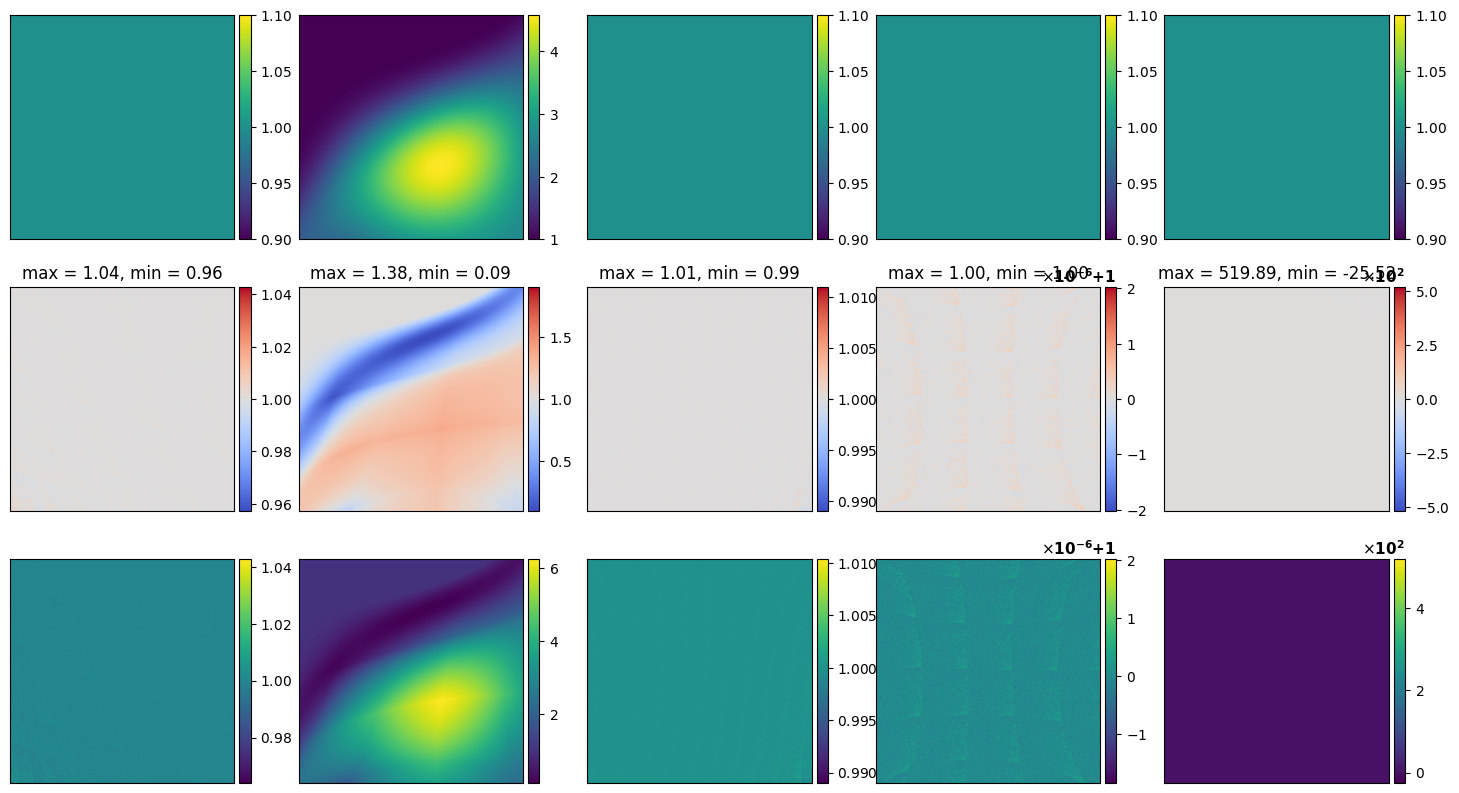

In [12]:
fig, ax = plt.subplots(3, len(radii_s), figsize = (18, 10))
for (i, (point, radius, majorant, color)) in enumerate(zip(points_np, radius_np, majorants.numpy(), colors)):
    α_im, σ_im = rasterize_sphere(Array2f(point), Float(radius), resolution, data_holder)
    sqrt_α = np.sqrt(α_im)
    sqrt_α[sqrt_α == 0] = np.nan
    plot_image(sqrt_α, ax[0, i])
    majorant = np.maximum(0.01, majorant)
    sampling_factor = 1 - σ_im / majorant
    sampling_factor[sampling_factor == 0] = np.nan
    max_sampling = np.max(sampling_factor)
    min_sampling = np.min(sampling_factor)
    max_ = max(max_sampling - 1, 1 - min_sampling)  
    ax[1, i].set_title(f"max = {max_sampling:.2f}, min = {min_sampling:.2f}")
    plot_image(sampling_factor, ax[1, i], input_range = [1-max_, 1 + max_], cmap = "coolwarm")
    plot_image(sampling_factor * sqrt_α, ax[2, i])
    #sphere0 = patches.Ellipse([resolution[0]/2 + 0.5, resolution[0]/2], resolution[0], resolution[0], linewidth= 1,
    #                            fill = False, color = color)
    #sphere1 = patches.Ellipse([resolution[0]/2 + 0.5, resolution[0]/2], resolution[0], resolution[0], linewidth= 1,
    #                            fill = False, color = color)
    #sphere2 = patches.Ellipse([resolution[0]/2 + 0.5, resolution[0]/2], resolution[0], resolution[0], linewidth= 1,
    #                           fill = False, color = color)
    #ax[0, i].add_patch(sphere0)
    #ax[1, i].add_patch(sphere1)
    #ax[2, i].add_patch(sphere2)
    
ax[0][0].set_ylabel("")
ax[1][0].set_ylabel("")
ax[2][0].set_ylabel("")
    
plt.savefig("sampling.pdf",  bbox_inches='tight', pad_inches=0.04, dpi=300)
    